In [44]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed.` %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)


requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4
[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [45]:
import pandas as pd
import numpy as np 

df = pd.read_csv('../data/flight_data.csv')

# 1. Exploratory Data Analysis

## Preliminary Information

In [46]:
# get the shape of dataset
rows, cols = df.shape
print(f"The shape of the dataset is as follows: {rows} rows, {cols} cols.")

print(df.info())

The shape of the dataset is as follows: 998866 rows, 18 cols.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998866 entries, 0 to 998865
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   from_airport_code                998866 non-null  object 
 1   from_country                     998866 non-null  object 
 2   dest_airport_code                998866 non-null  object 
 3   dest_country                     998866 non-null  object 
 4   aircraft_type                    984952 non-null  object 
 5   airline_number                   998866 non-null  object 
 6   airline_name                     998866 non-null  object 
 7   flight_number                    998866 non-null  object 
 8   departure_time                   998866 non-null  object 
 9   arrival_time                     998866 non-null  object 
 10  duration                         998866 non-null  int64  
 11  sto

## Information on Target Variable
The chosen target variable is the CO2 emissions of a given flight, and it's a continuous variable since it covers a wide spectrum of values. 

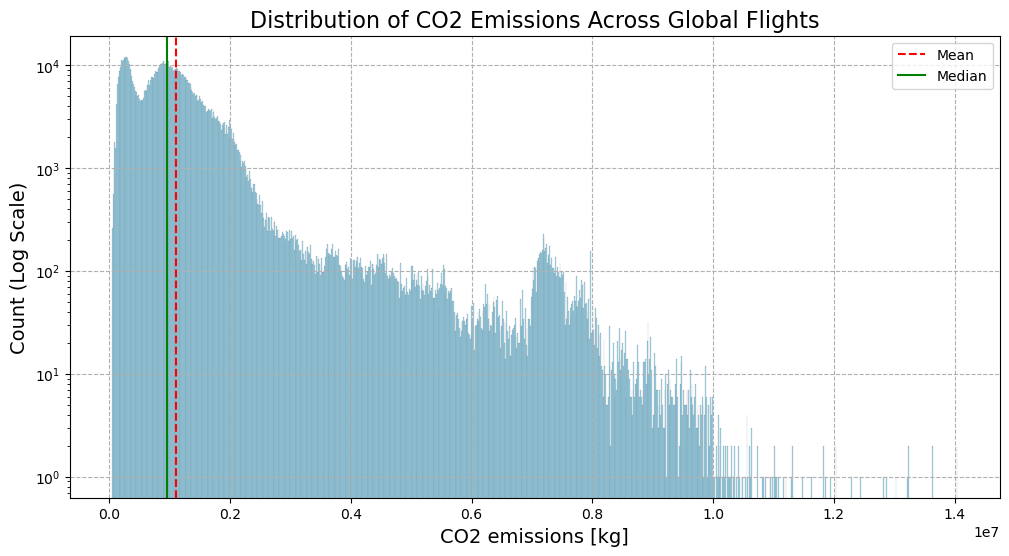

For the target variable, the mean is 1111010.421550144 & the median is 956000.0


In [47]:
# Visualize target variable
import matplotlib.pyplot as plt
import seaborn as sns

mean_val = df['co2_emissions'].mean()
median_val = df['co2_emissions'].median()

plt.figure(figsize=(12, 6))
count = int(np.sqrt(df.shape[0]))
sns.histplot(df['co2_emissions'], bins=count, color='skyblue', kde=False)

plt.yscale('log')
plt.axvline(mean_val, color='r', linestyle='--')
plt.axvline(median_val, color='g', linestyle='-')
plt.grid(True, linestyle='--')
plt.xlabel('CO2 emissions [kg]', fontsize=14)
plt.ylabel('Count (Log Scale)', fontsize=14)
plt.title('Distribution of CO2 Emissions Across Global Flights', fontsize=16)
plt.legend({'Mean': mean_val, 'Median': median_val})
# plt.savefig("co2_distribution.png", dpi=300)
plt.show()

print(f"For the target variable, the mean is {mean_val} & the median is {median_val}")

## More Visualizations & Insights
First, I'm going to look at which variables correlate the most with the target variable by using a correlation matrix. 

In [48]:
# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()
corr_with_target = corr_matrix['co2_emissions'].sort_values(key=abs, ascending=False)
corr_with_target = corr_with_target.drop('co2_emissions')
corr_with_target = corr_with_target.drop('avg_co2_emission_for_this_route')
print(corr_with_target.head(5))

price       0.724647
duration    0.492424
stops       0.377681
Name: co2_emissions, dtype: float64


## Continuous Variables

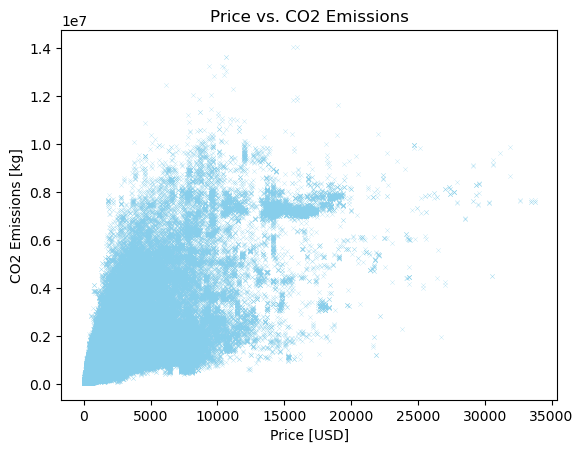

In [49]:
# Price VS CO2 Emissions
plt.figure()
sns.scatterplot(data=df, x='price', y='co2_emissions', marker='x', color='skyblue', alpha=0.6, s=10)
plt.title('Price vs. CO2 Emissions')
plt.xlabel('Price [USD]')
plt.ylabel('CO2 Emissions [kg]')
# plt.savefig("price_vs_co2_emissions.png", dpi=300)
plt.show()

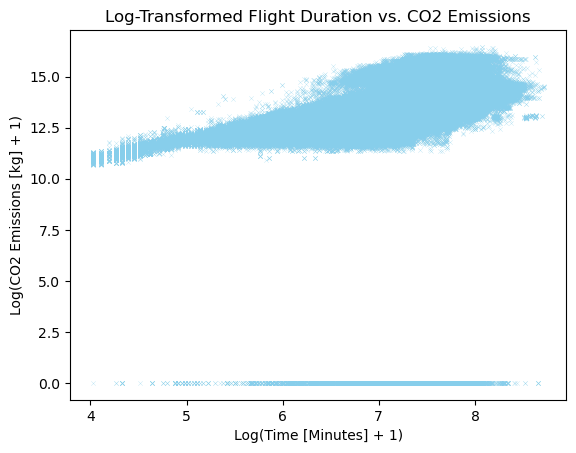

In [50]:
# Duration VS CO2 Emissions
log_duration = np.log1p(df['duration'])
log_co2_emissions = np.log1p(df['co2_emissions'].fillna(0))

plt.figure()
sns.scatterplot(x=log_duration, y=log_co2_emissions, marker='x', color='skyblue', alpha=0.6, s=10)
plt.title('Log-Transformed Flight Duration vs. CO2 Emissions')
plt.xlabel('Log(Time [Minutes] + 1)')
plt.ylabel('Log(CO2 Emissions [kg] + 1)')
# plt.savefig("duration_vs_co2_emissions.png", dpi=300)
plt.show()

## Ordinal Variables

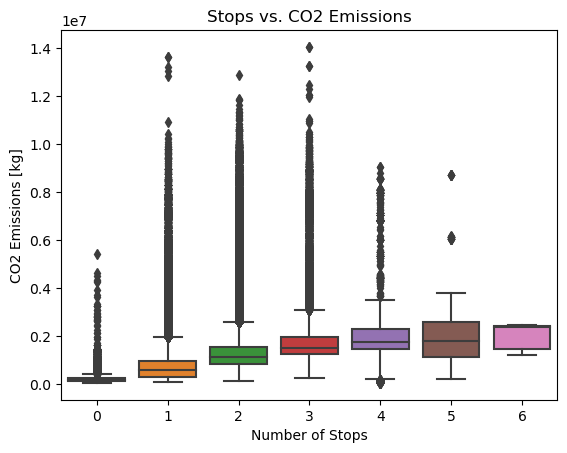

In [51]:
# Stops VS CO2 Emissions
plt.figure()
sns.boxplot(data=df, x='stops', y='co2_emissions')

plt.title('Stops vs. CO2 Emissions')
plt.xlabel('Number of Stops')
plt.ylabel('CO2 Emissions [kg]')
# plt.savefig("stops_vs_co2_emissions.png", dpi=300)
plt.show()

The box plot above suggests that flights with more stops will tend to have higher emissions. This also is confirmed with the correlation coefficient that we've seen above, of approximately 0.378. The heights of the boxes show that flights with 3+ stops have a wider range of CO2 emissions compared to flights with fewer stops - could be attributed to distance, passenger load, or the type of aircraft. Furthermore, the median line shifts upwards as the number of stops increases, which confirms the hypothesis that more stops generally correlate with higher emissions. The points outside the whiskers, the outliers, are especially abundant, which could point to the fact that this variable alone isn't enough to explain the variation in emissions. There are most likely other variables (that I mentioned) that contribute to the emissions.

## Categorical Variables

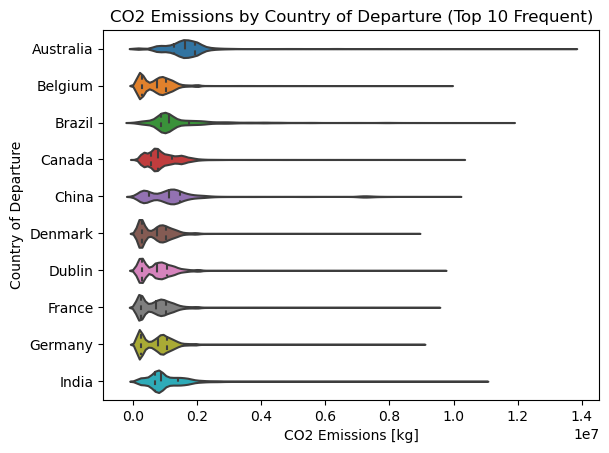

In [52]:
# from_country VS CO2_emissions
country_counts = df['from_country'].value_counts()
top_10 = country_counts.nlargest(10).index
filtered_df = df[df['from_country'].isin(top_10)]

plt.figure()
sns.violinplot(x='co2_emissions', y='from_country', data=filtered_df, inner='quartile')
plt.title('CO2 Emissions by Country of Departure (Top 10 Frequent)')
plt.xlabel('CO2 Emissions [kg]')
plt.ylabel('Country of Departure')
# plt.savefig("country_departure_vs_co2_emissions.png", dpi=300)
plt.show()

Since the width of the violin indicates the density of data points at that level, we can see that Australia has the highest CO2 emissions among all the countries that appear the most frequently in the dataset. The long "tail" for the violins observed could be due to multiple-leg flights, longer flights, or usage of aircraft with higher emissions.

**NOTE!** Dropping rows is a part of EDA, and I have decided that solely looking at single-leg flights would be the optimal approach. I am going to drop the rows that contain multi-leg flights from my dataset. This is because it is not possible to obtain precise per-leg information based on aircrafts. As can be seen from the entries above, the flights in the dataset involve multiple legs operated by different aircraft types, so it would be difficult to specifically isolate a specific aircraft's contribution to CO2 emissions when it comes to these rows.

In [53]:
# Clean dataset 
def is_single_aircraft_type(cell):
    return isinstance(cell, str) and '|' not in cell and cell != ''
single_aircraft_mask = df['aircraft_type'].apply(is_single_aircraft_type)

df_single_aircraft = df[single_aircraft_mask].copy()

# drop rows where target variable is missing
df_single_aircraft_clean = df_single_aircraft.dropna(subset=['co2_emissions'])
# drop columns that are closely related to the target variable / irrelevant
columns_to_drop = ['co2_percentage', 'avg_co2_emission_for_this_route', 'stops', 'currency', 'scan_date', 'airline_number', 'airline_name', 'flight_number']
df_single_aircraft_clean = df_single_aircraft_clean.drop(columns=columns_to_drop)

# reassign the variable df to our new filtered df_single_aircraft for simplicity
df = df_single_aircraft_clean.copy()

print(df.shape)

(16819, 10)


## Analyzing Missing Values

In [54]:
missing_value_placeholders = ['N/A', 'NA', 'Not Available', '', 'Unknown']
df.replace(missing_value_placeholders, np.nan, inplace=True)
missing_values = df.isnull().sum().sum()
print(f'There are {missing_values} missing values in the dataset')


# Iterating through each column in the DataFrame
for column in df.columns:
    missing_count = df[column].isnull().sum()
    all_value_count = df.shape[0]
    fraction_missing_values = missing_count / all_value_count
    print(f"{column} has {missing_count} missing values, "
          f"which accounts for {fraction_missing_values:.2%} of the entire data.")
missing_count = df['price'].isnull().sum()

There are 847 missing values in the dataset
from_airport_code has 0 missing values, which accounts for 0.00% of the entire data.
from_country has 0 missing values, which accounts for 0.00% of the entire data.
dest_airport_code has 0 missing values, which accounts for 0.00% of the entire data.
dest_country has 0 missing values, which accounts for 0.00% of the entire data.
aircraft_type has 0 missing values, which accounts for 0.00% of the entire data.
departure_time has 0 missing values, which accounts for 0.00% of the entire data.
arrival_time has 0 missing values, which accounts for 0.00% of the entire data.
duration has 0 missing values, which accounts for 0.00% of the entire data.
price has 847 missing values, which accounts for 5.04% of the entire data.
co2_emissions has 0 missing values, which accounts for 0.00% of the entire data.


# 2. Splitting

## Consideration of iid/non -iid dataset
First we need to consider whether this dataset is iid. I believe this dataset is non-iid because it has time-based attributes like departure_time -- flights that are closer in time might be more similar to each other. Similarity can also be geographical, since flights leaving from the same airports might share characteristics. Most obviously, I expect groups like price and duration to be correlated. I will be splitting on `price` for the following reasons:
1. From correlation matrix, there’s an underlying relationship between the price of a flight and CO2 emissions. Longer flights are often more expensive and produce more CO2
2. We want representative splits and by stratifying on price, we can ensure that each data subset contains a representative range of prices so that the model generalizes well
3. We also want to avoid bias - don’t want random split (eg. high priced flights could end up in training set). We don’t want nonrepresentative samples in each subset.

In [55]:
# Splitting (on price)
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer

X = df.drop(columns=['co2_emissions'])
y = df['co2_emissions']

# first, need to convert timestamps to float
def convert_timestamps(df, timestamp_columns):
    '''
    converts each timestamp to a total number of minutes since midnight
    '''
    for col in timestamp_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce', format='%Y-%m-%d %H:%M:%S')
            converted_col_name = col + '_converted'
            df[converted_col_name] = df[col].dt.hour * 60 + df[col].dt.minute
            df[col] = df[converted_col_name]
            df.drop(columns=[converted_col_name], inplace=True)
    return df

timestamp_columns = ['departure_time', 'arrival_time']

X = convert_timestamps(X.copy(), timestamp_columns)
# Need to fix the missing values in price so we can split on it
# but we have to split before preprocessing
# therefore we do a temporary imputation just for creating price bins
temp_price = df['price'].fillna(0)

price_bins = pd.qcut(temp_price, q=4, duplicates='drop')

X_train, X_other, y_train, y_other = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=price_bins
)

X_CV, X_test, y_CV, y_test = train_test_split(
    X_other, y_other, test_size=0.5, random_state=42
)

print(len(X_train), len(X_CV), len(X_test))

13455 1682 1682


# 3. Preprocessing

In [56]:
# Now, impute missing values separately for each dataset
imputer = IterativeImputer(random_state=42)

zero_mask_train = X_train['price'] == 0
if zero_mask_train.sum() > 0:
    X_train.loc[zero_mask_train, 'price'] = imputer.fit_transform(X_train.loc[zero_mask_train, ['price']])
zero_mask_cv = X_CV['price'] == 0
if zero_mask_cv.sum() > 0:
    X_CV.loc[zero_mask_cv, 'price'] = imputer.transform(X_CV.loc[zero_mask_cv, ['price']])

zero_mask_test = X_test['price'] == 0
if zero_mask_test.sum() > 0:
    X_test.loc[zero_mask_test, 'price'] = imputer.transform(X_test.loc[zero_mask_test, ['price']])

# X_train['price'] = imputer.fit_transform(X_train[['price']])
# X_CV['price'] = imputer.transform(X_CV[['price']])
# X_test['price'] = imputer.transform(X_test[['price']])

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin


# collect the various features - notice we don't have ordinal features anymore
cat_ftrs = ['from_airport_code', 'from_country', 'dest_airport_code', 'dest_country', 'aircraft_type']
num_ftrs = ['departure_time', 'arrival_time', 'duration', 'price']


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42)),
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs)
    ])

Let's look at the shape of the dataset after preprocessing.

In [58]:
X_preprocessed = preprocessor.fit_transform(X)
print("Shape of preprocessed data:", X_preprocessed.shape)

Shape of preprocessed data: (16819, 213)


# 4. Choosing Evaluation Metric

## Implementing Regression Baselines
We want to calculate the baseline metrics (R^2, MSE, RMSE, MAE) for the models later, so we first have to establish simple baseline predictions. I will use the mean of `y_train` as a baseline prediction for each instance in `y_test`.

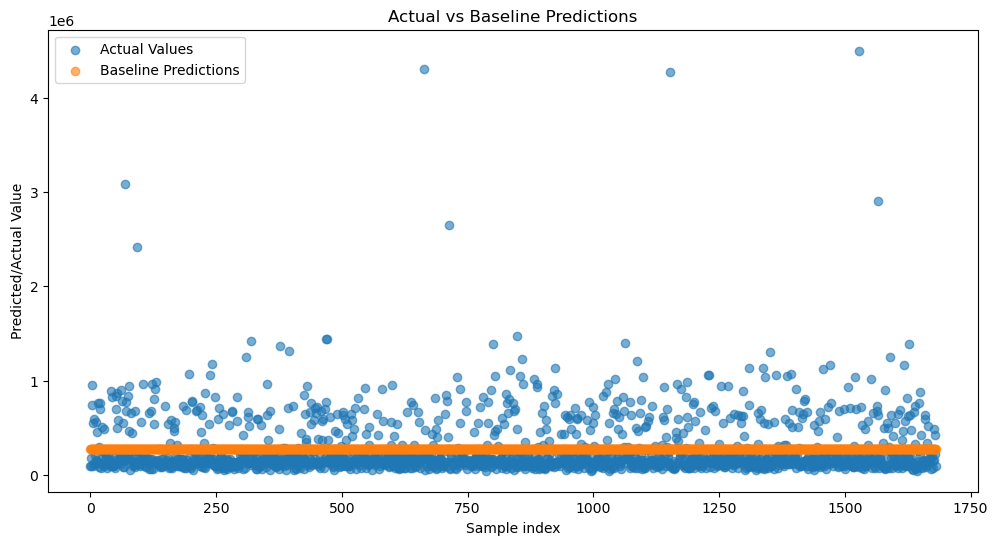

Baseline R^2: -0.000
Baseline MSE: 109342193118.233
Baseline RMSE: 330669.311
Baseline MAE: 204938.435


In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
baseline_predictions = np.full(shape=y_test.shape, fill_value=y_train.mean())

baseline_r2 = r2_score(y_test, baseline_predictions)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test, baseline_predictions)

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_test)), baseline_predictions, label='Baseline Predictions', alpha=0.6)
plt.title('Actual vs Baseline Predictions')
plt.xlabel('Sample index')
plt.ylabel('Predicted/Actual Value')
plt.legend()
# plt.savefig("baseline_evaluation.png", dpi=300)
plt.show()

print(f"Baseline R^2: {baseline_r2:.3f}")
print(f"Baseline MSE: {baseline_mse:.3f}")
print(f"Baseline RMSE: {baseline_rmse:.3f}")
print(f"Baseline MAE: {baseline_mae:.3f}")

# 5. Choosing ML Techniques & 6. Cross-Validation

## Starting with simple model like LinearRegression

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])  

param_grid = [{
    'regressor': [LinearRegression()],
}, {
    'regressor': [Lasso(max_iter=10000, tol=0.1, random_state=42)],
    'regressor__alpha': [10, 15, 20, 30, 50, 100]  
}, {
    'regressor': [Ridge(max_iter=10000, tol=0.05, random_state=42)],
    'regressor__alpha': [10, 15, 20, 30, 50, 100]  
}]

def evaluate_model(model, X_train, y_train, cv=5):
    mse_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
    rmse_scores = np.sqrt(mse_scores)
    r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv)

    mean_mse = np.mean(mse_scores)
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)
    std_mse = np.std(mse_scores)
    std_rmse = np.std(rmse_scores)
    std_r2 = np.std(r2_scores)

    return mean_mse, mean_rmse, mean_r2, std_mse, std_rmse, std_r2

for params in param_grid:
    pipeline.set_params(**{k: v[0] for k, v in params.items()}) 
    mean_mse, mean_rmse, mean_r2, std_mse, std_rmse, std_r2 = evaluate_model(pipeline, X_train, y_train)
    print(f"Params: {params}")
    print(f"Mean MSE: {mean_mse:.3f}, Mean RMSE: {mean_rmse:.3f}, Mean R²: {mean_r2:.3f}")
    print(f"Std MSE: {std_mse:.3f}, Std RMSE: {std_rmse:.3f}, Std R²: {std_r2:.3f}")

# # find best model
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=0)
# grid_search.fit(X_train, y_train)

# # using the best model on the test set
# y_pred = grid_search.predict(X_test)
# test_mse = mean_squared_error(y_test, y_pred)
# test_rmse = np.sqrt(test_mse)
# test_r2 = r2_score(y_test, y_pred)

# print(f'Test MSE: {test_mse:.3f}')
# print(f'Test RMSE: {test_rmse:.3f}')
# print(f'Test R^2 Score: {test_r2:.3f}')

Params: {'regressor': [LinearRegression()]}
Mean MSE: 16093517414.237, Mean RMSE: 125249.787, Mean R²: 0.812
Std MSE: 5270433010.187, Std RMSE: 20149.649, Std R²: 0.037
Params: {'regressor': [Lasso(alpha=10, max_iter=10000, random_state=42, tol=0.1)], 'regressor__alpha': [10, 15, 20, 30, 50, 100]}
Mean MSE: 16405479353.001, Mean RMSE: 126585.675, Mean R²: 0.808
Std MSE: 5147865657.522, Std RMSE: 19533.210, Std R²: 0.035
Params: {'regressor': [Ridge(alpha=10, max_iter=10000, random_state=42, tol=0.05)], 'regressor__alpha': [10, 15, 20, 30, 50, 100]}
Mean MSE: 18987752759.289, Mean RMSE: 136577.319, Mean R²: 0.777
Std MSE: 5153024597.014, Std RMSE: 18286.299, Std R²: 0.031


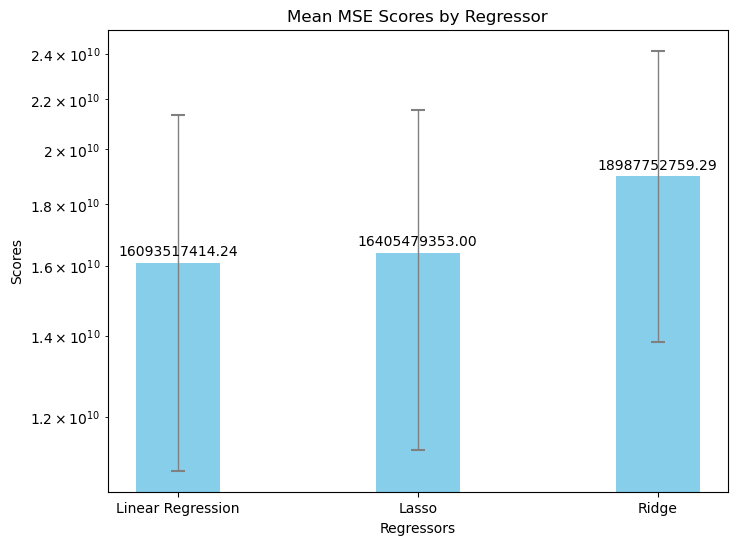

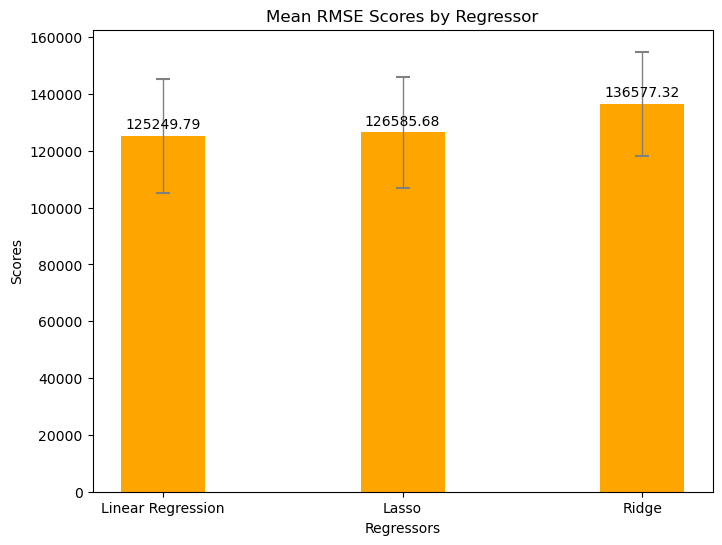

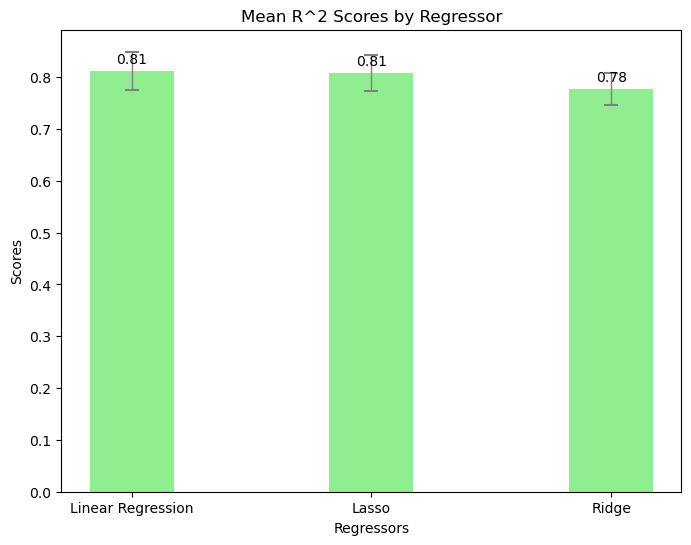

In [61]:
# plot the results
regressors = ['Linear Regression', 'Lasso', 'Ridge']
mse = [16093517414.237, 16405479353.001, 18987752759.289]
rmse = [125249.787, 126585.675, 136577.319]
r2 = [0.812, 0.808, 0.777]
mse_std = [5270433010.187, 5147865657.522, 5153024597.014]
rmse_std = [20149.649, 19533.210, 18286.299]
r2_std = [0.037, 0.035, 0.031]

x = np.arange(len(regressors))  
width = 0.35  

def create_bar_chart(ax, scores, stddevs, title, color):
    bars = ax.bar(x, scores, width, yerr=stddevs, color=color, capsize=5, ecolor='gray', error_kw={'elinewidth':1, 'capthick':1.5})
    ax.set_xlabel('Regressors')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(regressors)

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# MSE
fig, ax = plt.subplots(figsize=(8, 6))
create_bar_chart(ax, mse, mse_std, 'Mean MSE Scores by Regressor', 'skyblue')
plt.yscale('log') 
plt.savefig("linear_MSE_regressor.png", dpi=300)
plt.show()

# RMSE 
fig, ax = plt.subplots(figsize=(8, 6))
create_bar_chart(ax, rmse, rmse_std, 'Mean RMSE Scores by Regressor', 'orange')
plt.savefig("linear_RMSE_regressor.png", dpi=300)
plt.show()

# R^2
fig, ax = plt.subplots(figsize=(8, 6))
create_bar_chart(ax, r2, r2_std, 'Mean R^2 Scores by Regressor', 'lightgreen')
plt.savefig("linear_R^2_regressor.png", dpi=300)
plt.show()

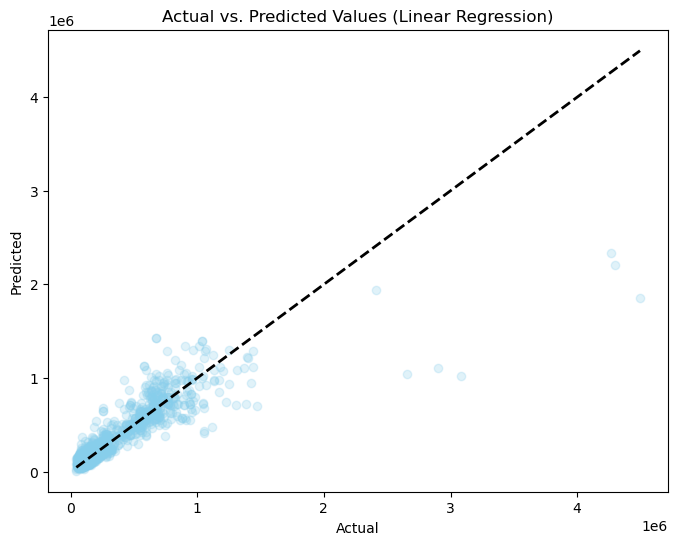

In [19]:
# plot true vs predicted for LR only
pipeline.set_params(**{'regressor': LinearRegression()})

pipeline.fit(X_train, y_train)
y_pred_linear = pipeline.predict(X_test)

# plotting actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.25, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Linear Regression)')
# plt.savefig("LR_actual_vs_predicted.png", dpi=300)
plt.show()

The scatter plot above shows how well the predicted values align with the actual values. If a prediction is accurate, it will be on the line, whereas points that are further from the line indicate less accurate predictions. 

## RandomForestRegressor

For convenience, the below cell has been commented out in order to speed up computation, but it can be seen that I tested a variety of hyperparameters before selecting the best one to run through a range of random states.

In [20]:
# from sklearn.ensemble import RandomForestRegressor

# rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('regressor', RandomForestRegressor(random_state=42))])

# rf_param_grid = {
#     'regressor__n_estimators': [50, 55, 60],
#     'regressor__max_depth': [15, 20, 25]
# }

# rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=4, scoring='r2')
# rf_grid_search.fit(X_train, y_train)

# y_pred = rf_grid_search.predict(X_test)
# print(f'rf Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}')
# print(f'rf rmse: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
# # print(f'rf R^2 Score: {r2_score(y_test, y_pred):.3f}')

# # print(f'rf Best model: {grid_search.best_model_}')
# print(f'rf Best parameters: {rf_grid_search.best_params_}')
# print(f'rf Best R^2 score: {rf_grid_search.best_score_}')

Here is what was logged when running the above cell: `rf Mean Squared Error: 8578311286.428
rf rmse: 92619.173
rf Best parameters: {'regressor__max_depth': 20, 'regressor__n_estimators': 60}
rf Best R^2 score: 0.9166482175672835`

In [21]:
# calculating metrics for mean squared error, using best model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

rf_mse_scores = []
rf_rmse_scores = []
rf_r2_scores = []
y_pred_rf = []
rf_shap_values = []

for state in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(max_depth=20, n_estimators=60, random_state=state))
    ])

    rf_pipeline.fit(X_train, y_train)
    y_pred = rf_pipeline.predict(X_test)
    y_pred_rf.append(y_pred)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    rf_mse_scores.append(mse)
    rf_rmse_scores.append(rmse)
    rf_r2_scores.append(r2)

mean_mse = np.mean(rf_mse_scores)
std_mse = np.std(rf_mse_scores)
mean_rmse = np.mean(rf_rmse_scores)
std_rmse = np.std(rf_rmse_scores)
mean_r2 = np.mean(rf_r2_scores)
std_r2 = np.std(rf_r2_scores)

print(f"Mean MSE: {mean_mse:.3f}, Std MSE: {std_mse:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f}, Std RMSE: {std_rmse:.3f}")
print(f"Mean R^2 Score: {mean_r2:.3f}, Std R^2 Score: {std_r2:.3f}")

Mean MSE: 8295257524.084, Std MSE: 1918814978.941
Mean RMSE: 90546.965, Std RMSE: 9823.678
Mean R^2 Score: 0.906, Std R^2 Score: 0.019


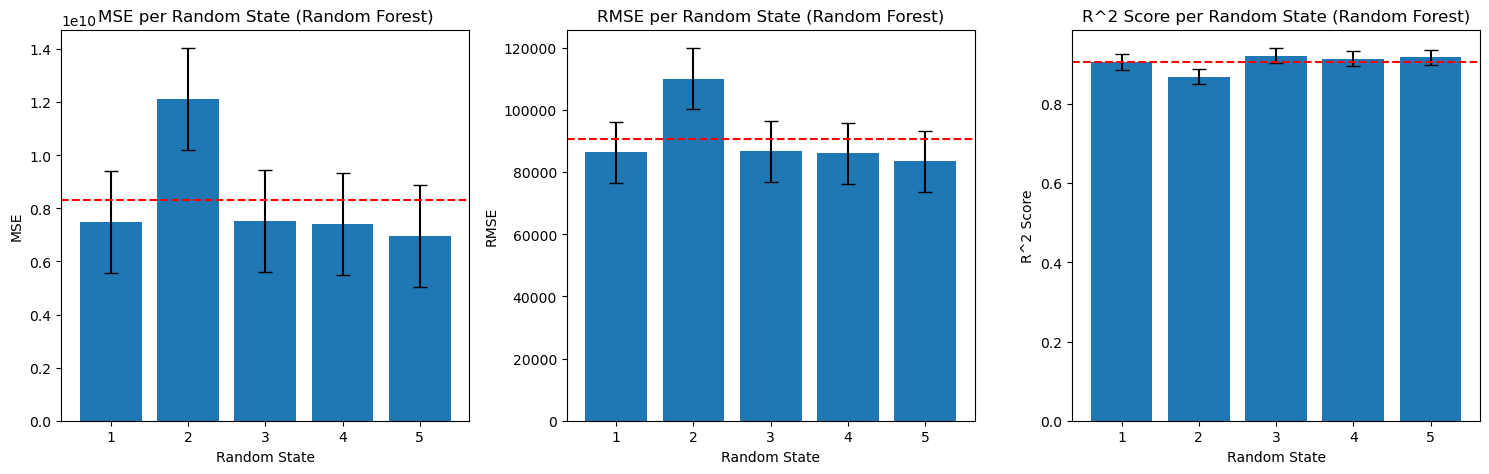

In [22]:
# Plotting
random_states = list(range(1, 6))

plt.figure(figsize=(15, 5))

# MSE
plt.subplot(1, 3, 1)
plt.bar(random_states, rf_mse_scores, yerr=std_mse, capsize=5)
plt.axhline(y=mean_mse, color='r', linestyle='--')
plt.title('MSE per Random State (Random Forest)')
plt.xlabel('Random State')
plt.ylabel('MSE')
plt.xticks(random_states)

# RMSE 
plt.subplot(1, 3, 2)
plt.bar(random_states, rf_rmse_scores, yerr=std_rmse, capsize=5)
plt.axhline(y=mean_rmse, color='r', linestyle='--')
plt.title('RMSE per Random State (Random Forest)')
plt.xlabel('Random State')
plt.ylabel('RMSE')
plt.xticks(random_states)

# R2 Score
plt.subplot(1, 3, 3)
plt.bar(random_states, rf_r2_scores, yerr=std_r2, capsize=5)
plt.axhline(y=mean_r2, color='r', linestyle='--')
plt.title('R^2 Score per Random State (Random Forest)')
plt.xlabel('Random State')
plt.ylabel('R^2 Score')
plt.xticks(random_states)

plt.tight_layout()
# plt.savefig("RF_metrics.png", dpi=300)
plt.show()

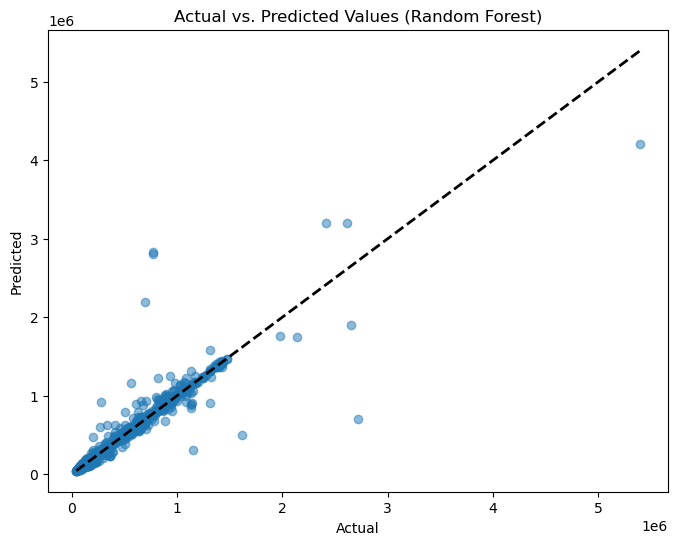

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf[-1], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Random Forest)')
# plt.savefig("RF_actual_vs_predicted.png", dpi=300)
plt.show()

## XGBoost Regression

In [64]:
from xgboost import XGBRegressor
xgb_mse_scores = []
xgb_rmse_scores = []
xgb_r2_scores = []
y_pred_xgb = []

# run under different random states
for state in range(5):
    xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', XGBRegressor(random_state=state))])
    # xgb_param_grid = {
    #     'regressor__n_estimators': [125, 150, 175, 200, 225],
    #     'regressor__max_depth': [4, 5, 6],
    #     'regressor__learning_rate': [0.15, 0.2, 0.25],
    # }

    xgb_param_grid = {
        'regressor__n_estimators': [225],
        'regressor__max_depth': [5],
        'regressor__learning_rate': [0.2]
    }

    xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, scoring='r2', verbose=0)
    xgb_grid_search.fit(X_train, y_train)

    y_pred = xgb_grid_search.predict(X_test)
    y_pred_xgb.append(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    xgb_mse_scores.append(mse)
    xgb_rmse_scores.append(rmse)
    xgb_r2_scores.append(r2)
    

# calculations
mean_mse = np.mean(xgb_mse_scores)
std_mse = np.std(xgb_mse_scores)
mean_rmse = np.mean(xgb_rmse_scores)
std_rmse = np.std(xgb_rmse_scores)
mean_r2 = np.mean(xgb_r2_scores)
std_r2 = np.std(xgb_r2_scores)

print(f"Mean MSE: {mean_mse:.3f}, Std MSE: {std_mse:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f}, Std RMSE: {std_rmse:.3f}")
print(f"Mean R² Score: {mean_r2:.3f}, Std R² Score: {std_r2:.3f}")

Mean MSE: 6112169763.538, Std MSE: 0.000
Mean RMSE: 78180.367, Std RMSE: 0.000
Mean R² Score: 0.944, Std R² Score: 0.000


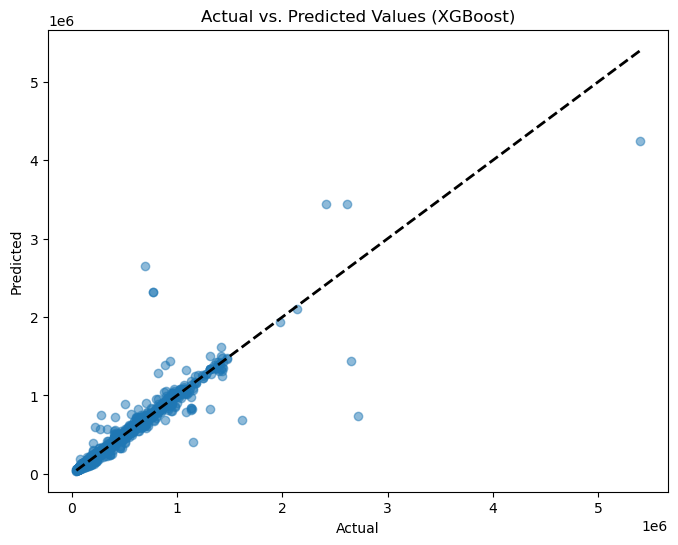

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb[-1], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (XGBoost)')
# plt.savefig("XGB_actual_vs_predicted.png", dpi=300)
plt.show()

## SVM Regressor

For convenience, the below cell has been commented out in order to speed up computation, but it can be seen that I tested a variety of hyperparameters before selecting the best one to run through a range of random states.

In [26]:
# from sklearn.svm import SVR

# svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                                ('regressor', SVR())])

# svm_param_grid = {
#     'regressor__C': [100, 150, 160, 190, 200],
#     'regressor__gamma': ['scale'],
#     'regressor__kernel': ['linear', 'rbf', 'poly'],
# }

# svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='r2', verbose=1)
# svm_grid_search.fit(X_train, y_train)

# print(f'svm Best parameters: {svm_grid_search.best_params_}')
# print(f'svm Best R^2 score: {svm_grid_search.best_score_}')

# y_pred = svm_grid_search.predict(X_test)
# print(f'svm Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}')
# print(f'svm RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
# print(f'svm R^2 Score: {r2_score(y_test, y_pred):.3f}')

The results that were printed from the above cell were: 
`Fitting 5 folds for each of 15 candidates, totalling 75 fits
svm Best parameters: {'regressor__C': 160, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
svm Best R^2 score: 0.712354061807652
svm Mean Squared Error: 18822342464.733
svm RMSE: 137194.542
svm R^2 Score: 0.778`

In [67]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

svm_mse_scores = []
svm_rmse_scores = []
svm_r2_scores = []
y_pred_svm = []

for state in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)

    svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', SVR(gamma='scale', kernel='linear'))])

    svm_param_grid = {
        'regressor__C': [160],
    }

    svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='r2', verbose=0)
    svm_grid_search.fit(X_train, y_train)
    y_pred = svm_grid_search.predict(X_test)
    y_pred_svm.append(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    svm_mse_scores.append(mse)
    svm_rmse_scores.append(rmse)
    svm_r2_scores.append(r2)

# Averaging the scores
mean_mse = np.mean(svm_mse_scores)
mean_rmse = np.mean(svm_rmse_scores)
mean_r2 = np.mean(svm_r2_scores)
std_mse = np.std(svm_mse_scores)
std_rmse = np.std(svm_rmse_scores)
std_r2 = np.std(svm_r2_scores)


print(f"Mean MSE: {mean_mse:.3f}, Std MSE: {std_mse:.3f}")
print(f"Mean RMSE: {mean_rmse:.3f}, Std RMSE: {std_rmse:.3f}")
print(f"Mean R² Score: {mean_r2:.3f}, Std R² Score: {std_r2:.3f}")

Mean MSE: 23458334613.151, Std MSE: 3961720747.514
Mean RMSE: 152594.891, Std RMSE: 13158.039
Mean R² Score: 0.735, Std R² Score: 0.031


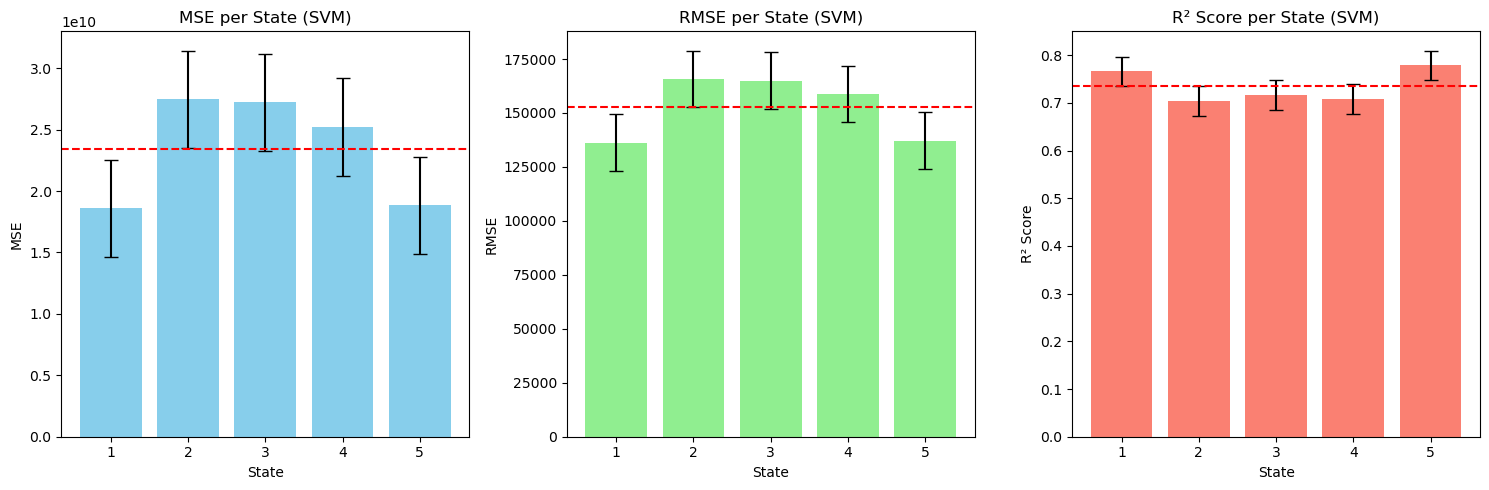

In [28]:
import matplotlib.pyplot as plt

# Calculating standard deviations
std_mse = np.std(svm_mse_scores)
std_rmse = np.std(svm_rmse_scores)
std_r2 = np.std(svm_r2_scores)

states = list(range(1, 6))

plt.figure(figsize=(15, 5))

# MSE Plot
plt.subplot(1, 3, 1)
plt.bar(states, svm_mse_scores, yerr=std_mse, capsize=5, color='skyblue')
plt.axhline(y=mean_mse, color='r', linestyle='--')
plt.title('MSE per State (SVM)')
plt.xlabel('State')
plt.ylabel('MSE')
plt.xticks(states)

# RMSE Plot
plt.subplot(1, 3, 2)
plt.bar(states, svm_rmse_scores, yerr=std_rmse, capsize=5, color='lightgreen')
plt.axhline(y=mean_rmse, color='r', linestyle='--')
plt.title('RMSE per State (SVM)')
plt.xlabel('State')
plt.ylabel('RMSE')
plt.xticks(states)

# R2 Score Plot
plt.subplot(1, 3, 3)
plt.bar(states, svm_r2_scores, yerr=std_r2, capsize=5, color='salmon')
plt.axhline(y=mean_r2, color='r', linestyle='--')
plt.title('R² Score per State (SVM)')
plt.xlabel('State')
plt.ylabel('R² Score')
plt.xticks(states)

plt.tight_layout()
# plt.savefig("SVM_metrics.png", dpi=300)
plt.show()

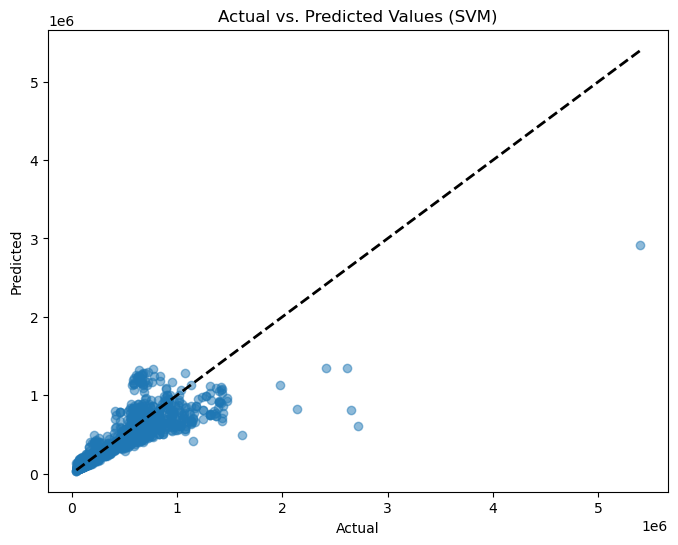

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_svm[-1], alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (SVM)')
# plt.savefig("SVM_actual_vs_predicted.png", dpi=300)
plt.show()

# 7. Interpretation

Here we calculate at least 3 different global feature importances.

In [30]:
# Using feature importances from RF regressor
rf_regressor = RandomForestRegressor(max_depth=20, n_estimators=60, random_state=42)
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', rf_regressor)
])
rf_pipeline.fit(X_train, y_train)

rf_feature_importances = rf_pipeline.named_steps['regressor'].feature_importances_
print("Feature Importances:")
for feature, importance in zip(X_train.columns, rf_feature_importances):
    print(f"{feature}: {importance:.4f}")

Feature Importances:
from_airport_code: 0.0089
from_country: 0.0063
dest_airport_code: 0.7794
dest_country: 0.1245
aircraft_type: 0.0000
departure_time: 0.0000
arrival_time: 0.0001
duration: 0.0001
price: 0.0051


In [31]:
# Using feature importances from XGB
xgb_regressor = XGBRegressor(n_estimators=225, max_depth=5, learning_rate=0.2, random_state=0)
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_regressor)
])
xgb_pipeline.fit(X_train, y_train)

xgb_feature_importances = xgb_pipeline.named_steps['regressor'].feature_importances_
print("Feature Importances:")
for feature, importance in zip(X_train.columns, xgb_feature_importances):
    print(f"{feature}: {importance:.4f}")

Feature Importances:
from_airport_code: 0.0042
from_country: 0.0048
dest_airport_code: 0.2385
dest_country: 0.0266
aircraft_type: 0.0021
departure_time: 0.0008
arrival_time: 0.0017
duration: 0.0028
price: 0.0584


In [32]:
# PERMUTATION FEATURE IMPORTANCE XGBOOST
from sklearn.inspection import permutation_importance

xgb_permutation_importances = permutation_importance(xgb_pipeline, X_test, y_test, n_repeats=10, random_state=0)
xgb_permutation_importance_scores = xgb_permutation_importances.importances_mean
print("Permutation Feature Importances (XGBoost):")
for feature, importance in zip(X_test.columns, xgb_permutation_importance_scores):
    print(f"{feature}: {importance:.4f}")

Permutation Feature Importances (XGBoost):
from_airport_code: 0.0170
from_country: 0.0023
dest_airport_code: 0.0105
dest_country: 0.0046
aircraft_type: 0.0407
departure_time: 0.0046
arrival_time: -0.0005
duration: 1.3096
price: 0.1853


In [33]:
# PERMUTATION FEATURE IMPORTANCE RANDOMFOREST
rf_permutation_importances = permutation_importance(rf_pipeline, X_test, y_test, n_repeats=10, random_state=0)
rf_permutation_importance_scores = rf_permutation_importances.importances_mean

print("Permutation Feature Importances (Random Forest):")
for feature, importance in zip(X_test.columns, rf_permutation_importance_scores):
    print(f"{feature}: {importance:.4f}")

Permutation Feature Importances (Random Forest):
from_airport_code: -0.0124
from_country: -0.0110
dest_airport_code: 0.0067
dest_country: -0.0051
aircraft_type: 0.0385
departure_time: 0.0165
arrival_time: 0.0012
duration: 1.3247
price: 0.1714


Next, we calculate SHAP values for local feature importance. Due to its high computational intensity, I have selected one model using the tuned hyperparameters, which gives us an idea of the feature importances for this specific model. 

In [34]:
# SHAP FOR RF
import shap

def get_feature_names(column_transformer):
    output_features = []
    for name, transformer, original_features in column_transformer.transformers_:
        if name == 'remainder':
            continue

        if isinstance(transformer, Pipeline):
            if isinstance(transformer.steps[-1][1], OneHotEncoder):
                onehot_transformer = transformer.steps[-1][1]
                onehot_features = onehot_transformer.get_feature_names_out(original_features)
                output_features.extend(onehot_features)
            else:
                output_features.extend(original_features)
        else:
            output_features.extend(original_features)

    return output_features



X_train_shap = preprocessor.fit_transform(X_train)
X_test_shap = preprocessor.transform(X_test)
new_feature_names = get_feature_names(preprocessor)

if isinstance(X_test_shap, np.ndarray):
    X_test_dense = X_test_shap
else:  # Assuming it's a sparse matrix
    X_test_dense = X_test_shap.toarray()

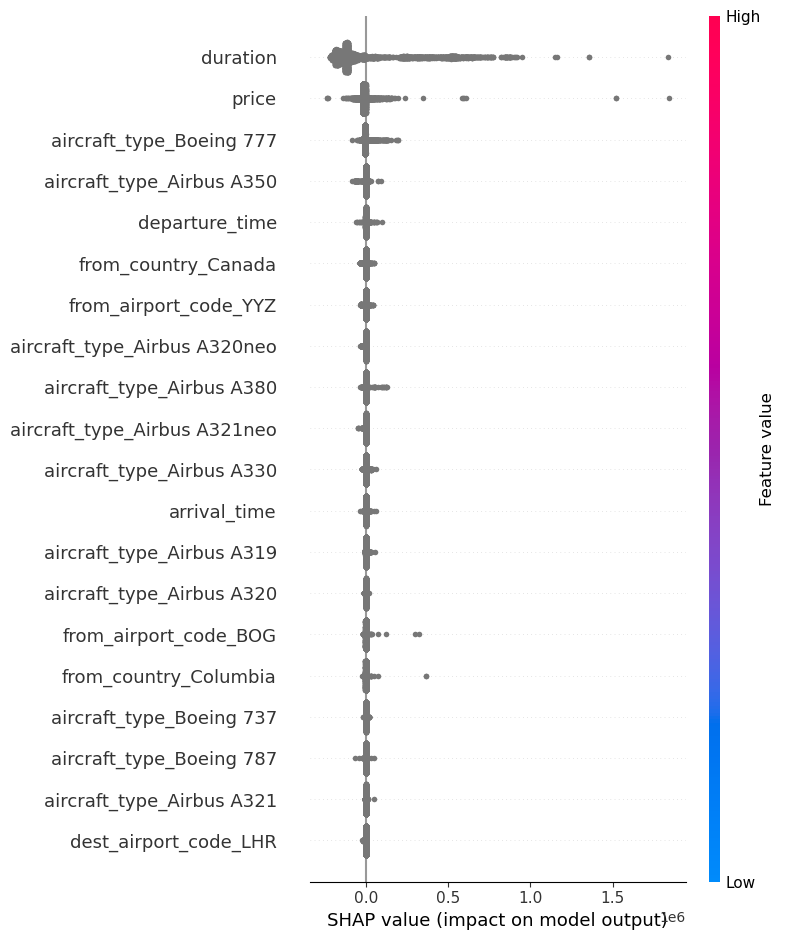

In [35]:
# RF 
shap.initjs()
rf_model = RandomForestRegressor(max_depth=20, n_estimators=60, random_state=42)
rf_model.fit(X_train_shap, y_train)
rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test_dense)
shap_fig = plt.figure()
shap.summary_plot(rf_shap_values, X_test_shap, feature_names=new_feature_names)
# shap_fig.savefig("RF_shap_summary_plot.png", bbox_inches='tight', dpi=300)

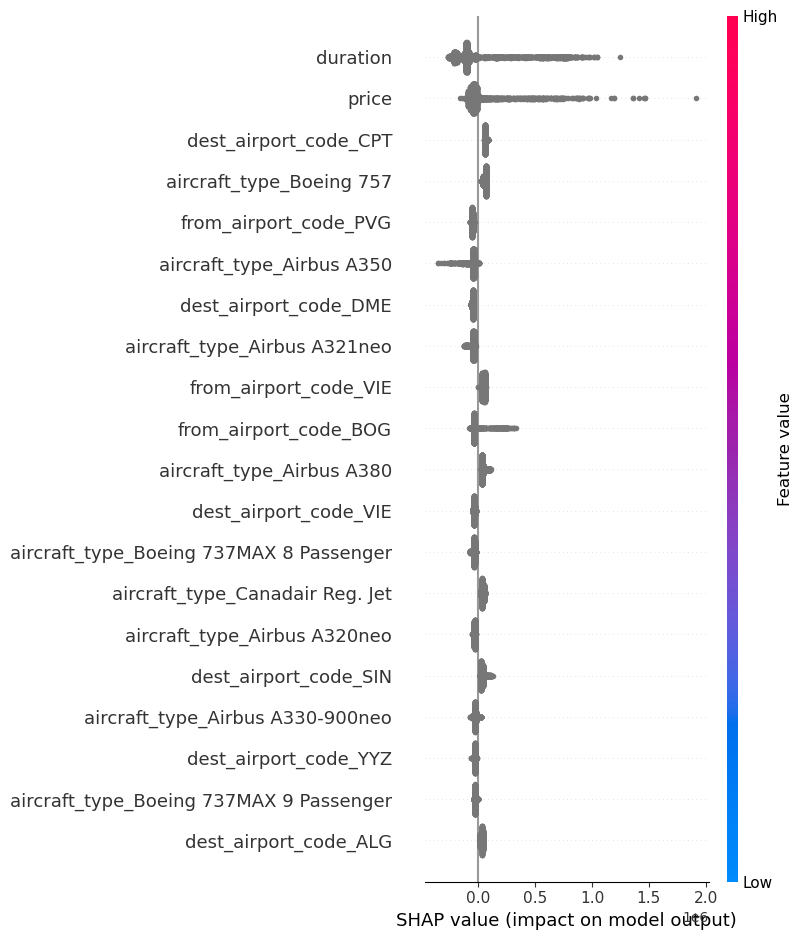

In [36]:
# XGBOOST
shap.initjs()
xgb_model = XGBRegressor(n_estimators=225, max_depth=5,learning_rate=0.2)
xgb_model.fit(X_train_shap, y_train)
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X_test_dense)

shap_fig = plt.figure()
shap.summary_plot(xgb_shap_values, X_test_shap, feature_names=new_feature_names)
# shap_fig.savefig("XGB_shap_summary_plot.png", bbox_inches='tight', dpi=300)

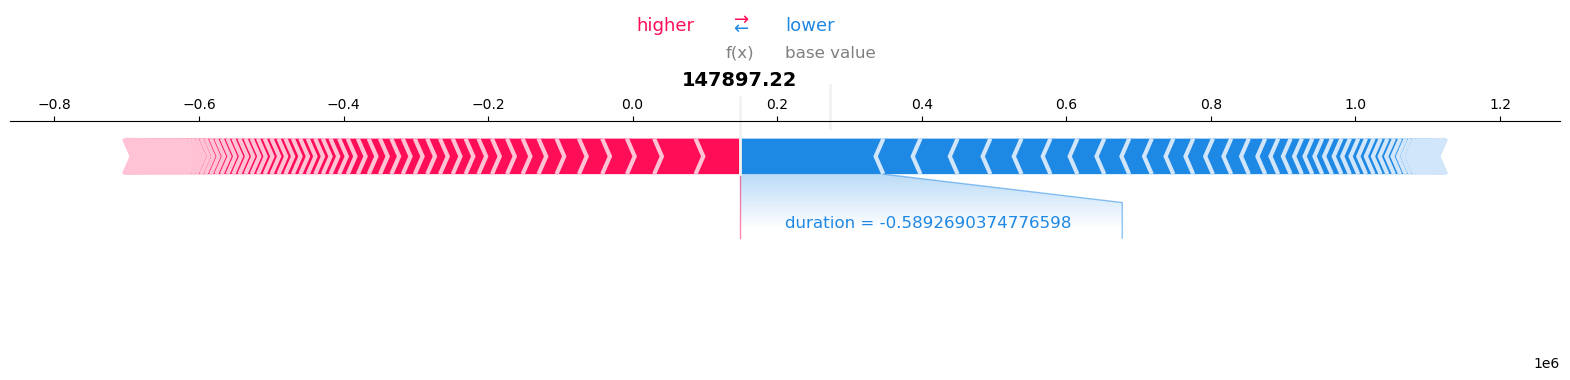

In [37]:
shap.initjs()
index = 42
X_test_dense = X_test_shap.toarray() if not isinstance(X_test_shap, np.ndarray) else X_test_shap

force_plot = shap.force_plot(
    xgb_explainer.expected_value, 
    xgb_shap_values[index, :], 
    features=X_test_dense[index, :], 
    feature_names=new_feature_names,
    matplotlib=True
)

# plt.title('Feature Impact on XGBoost Prediction for Data Point (Index = 42)')
# plt.savefig("XGB_shap_force_plot.png", bbox_inches='tight', dpi=300)

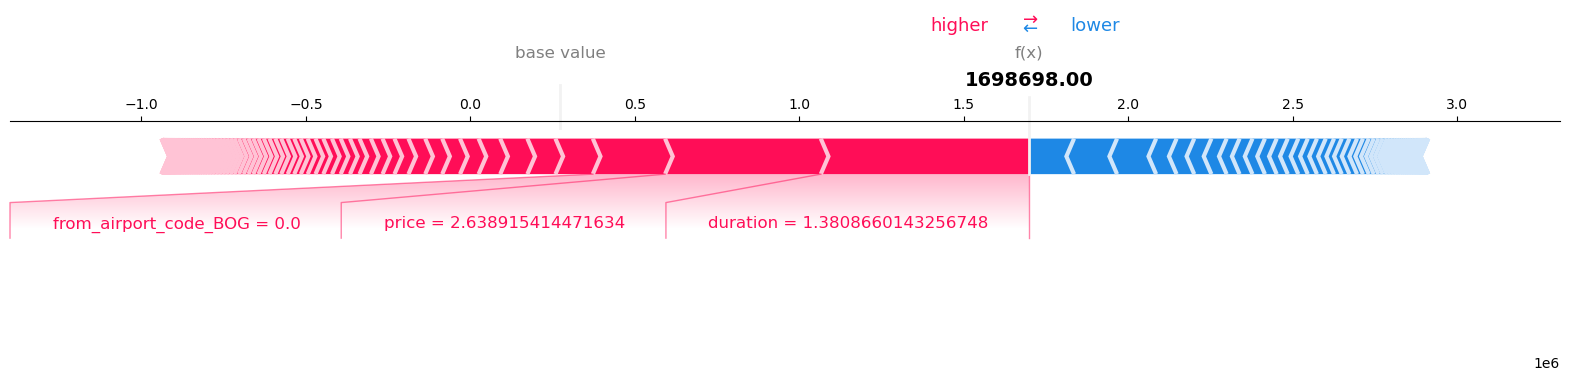

In [38]:
index = 0
X_test_dense = X_test_shap.toarray() if not isinstance(X_test_shap, np.ndarray) else X_test_shap

force_plot = shap.force_plot(
    xgb_explainer.expected_value, 
    xgb_shap_values[index, :], 
    features=X_test_dense[index, :], 
    feature_names=new_feature_names,
    matplotlib=True
)

# plt.savefig("XGB_shap_force_plot.png", bbox_inches='tight', dpi=300)

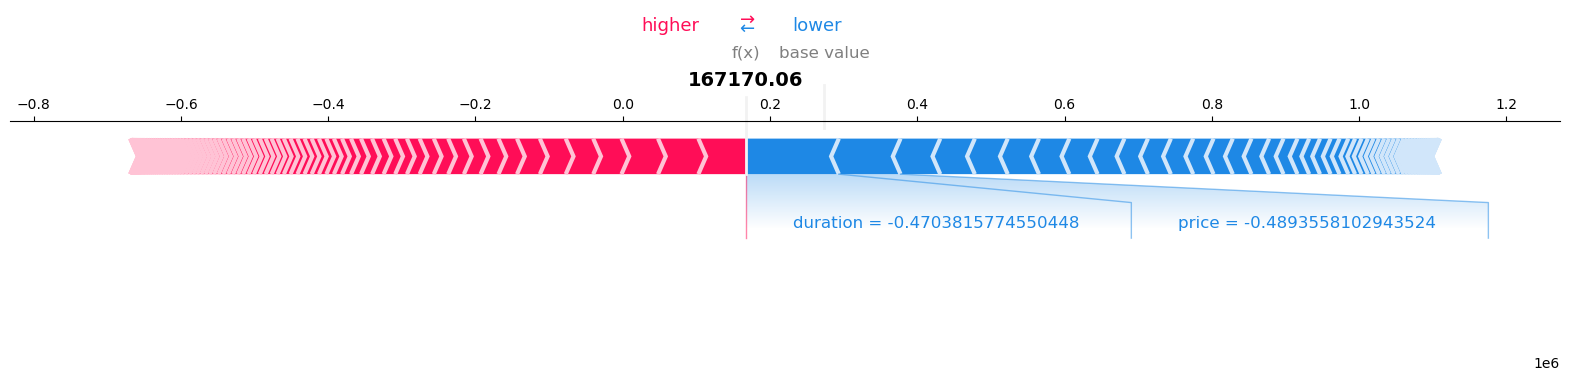

In [39]:
index = 1230
X_test_dense = X_test_shap.toarray() if not isinstance(X_test_shap, np.ndarray) else X_test_shap

force_plot = shap.force_plot(
    xgb_explainer.expected_value, 
    xgb_shap_values[index, :], 
    features=X_test_dense[index, :], 
    feature_names=new_feature_names,
    matplotlib=True
)

# plt.savefig("XGB_shap_force_plot.png", bbox_inches='tight', dpi=300)